# Text Classification


## Tokenization

In [1]:
import regex as re

def split_chars(text):
    return re.findall(r".", text)

In [2]:
chars = split_chars("The quick brown fox jumped over the lazy dog.")
chars[:12]

['T', 'h', 'e', ' ', 'q', 'u', 'i', 'c', 'k', ' ', 'b', 'r']

In [3]:
def split_words(text):
    return re.findall(r"[\w]+|[.,!?;]", text)

In [4]:
split_words("The quick brown fox jumped over the dog.")

['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'dog', '.']

In [5]:
vocabulary = {
    "[UNK]": 0,
    "the": 1,
    "quick": 2,
    "brown": 3,
    "fox": 4,
    "jumped": 5,
    "over": 6,
    "dog": 7,
    ".": 8,
}
words = split_words("The quick brown fox jumped over the lazy dog.")
indices = [vocabulary.get(word, 0) for word in words]
print(indices)

[0, 2, 3, 4, 5, 6, 1, 0, 7, 8]


In [6]:
class CharTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def split(self, inputs):
        return re.findall(r".", inputs)

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

In [7]:
import collections

def compute_char_vocabulary(inputs, max_size):
    char_counts = collections.Counter()
    for x in inputs:
        x = x.lower()
        tokens = re.findall(r".", x)
        char_counts.update(tokens)
    vocabulary = ["[UNK]"]
    most_common = char_counts.most_common(max_size - len(vocabulary))
    for token, count in most_common:
        vocabulary.append(token)
    return dict((token, i) for i, token in enumerate(vocabulary))

In [8]:
class WordTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def split(self, inputs):
        return re.findall(r"[\w]+|[.,!?;]", inputs)

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

In [9]:
def compute_word_vocabulary(inputs, max_size):
    word_counts = collections.Counter()
    for x in inputs:
        x = x.lower()
        tokens = re.findall(r"[\w]+|[.,!?;]", x)
        word_counts.update(tokens)
    vocabulary = ["[UNK]"]
    most_common = word_counts.most_common(max_size - len(vocabulary))
    for token, count in most_common:
        vocabulary.append(token)
    return dict((token, i) for i, token in enumerate(vocabulary))

In [10]:
from tensorflow import keras

filename = keras.utils.get_file(
    origin="https://www.gutenberg.org/files/2701/old/moby10b.txt",
)
moby_dick = list(open(filename, "r"))

vocabulary = compute_char_vocabulary(moby_dick, max_size=100)
char_tokenizer = CharTokenizer(vocabulary)

In [11]:
print("Vocabulary length:", len(vocabulary))

print("Vocabulary start:", list(vocabulary.keys())[:10])

print("Vocabulary end:", list(vocabulary.keys())[-10:])

print("Line length:", len(char_tokenizer(
    "Call me Ishmael. Some years ago--never mind how long precisely."
)))

Vocabulary length: 64
Vocabulary start: ['[UNK]', ' ', 'e', 't', 'a', 'o', 'n', 'i', 's', 'h']
Vocabulary end: ['@', '$', '%', '#', '=', '~', '&', '+', '<', '>']
Line length: 63


In [12]:
vocabulary = compute_word_vocabulary(moby_dick, max_size=2_000)
word_tokenizer = WordTokenizer(vocabulary)

In [13]:
print("Vocabulary length:", len(vocabulary))
print("Vocabulary start:", list(vocabulary.keys())[:5])
print("Vocabulary end:", list(vocabulary.keys())[-5:])
print("Line length:", len(word_tokenizer(
    "Call me Ishmael. Some years ago--never mind how long precisely."
)))

Vocabulary length: 2000
Vocabulary start: ['[UNK]', ',', 'the', '.', 'of']
Vocabulary end: ['tambourine', 'subtle', 'perseus', 'elevated', 'repose']
Line length: 13


In [14]:
data = [
    "the quick brown fox",
    "the slow brown fox",
    "the quick brown foxhound",
]

In [15]:
def count_and_split_words(data):
    counts = collections.Counter()
    for line in data:
        line = line.lower()
        for word in re.findall(r"[\w]+|[.,!?;]", line):
            chars = re.findall(r".", word)
            split_word = " ".join(chars)
            counts[split_word] += 1
    return dict(counts)

counts = count_and_split_words(data)

In [16]:
counts

{'t h e': 3,
 'q u i c k': 2,
 'b r o w n': 3,
 'f o x': 2,
 's l o w': 1,
 'f o x h o u n d': 1}

In [17]:
def count_pairs(counts):
    pairs = collections.Counter()
    for word, freq in counts.items():
        symbols = word.split()
        for pair in zip(symbols[:-1], symbols[1:]):
            pairs[pair] += freq
    return pairs

def merge_pair(counts, first, second):
    split = re.compile(f"(?<!\S){first} {second}(?!\S)")
    merged = f"{first}{second}"
    return {split.sub(merged, word): count for word, count in counts.items()}

for i in range(10):
    pairs = count_pairs(counts)
    first, second = max(pairs, key=pairs.get)
    counts = merge_pair(counts, first, second)
    print(list(counts.keys()))

['t h e', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['th e', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'br ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brown', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brown', 'fo x', 's l ow', 'fo x h o u n d']
['the', 'q u i c k', 'brown', 'fox', 's l ow', 'fox h o u n d']
['the', 'qu i c k', 'brown', 'fox', 's l ow', 'fox h o u n d']
['the', 'qui c k', 'brown', 'fox', 's l ow', 'fox h o u n d']


In [18]:
def compute_sub_word_vocabulary(dataset, vocab_size):
    counts = count_and_split_words(dataset)

    char_counts = collections.Counter()
    for word in counts:
        for char in word.split():
            char_counts[char] += counts[word]
    most_common = char_counts.most_common()
    vocab = ["[UNK]"] + [char for char, freq in most_common]
    merges = []

    while len(vocab) < vocab_size:
        pairs = count_pairs(counts)
        if not pairs:
            break
        first, second = max(pairs, key=pairs.get)
        counts = merge_pair(counts, first, second)
        vocab.append(f"{first}{second}")
        merges.append(f"{first} {second}")

    vocab = dict((token, index) for index, token in enumerate(vocab))
    merges = dict((token, rank) for rank, token in enumerate(merges))
    return vocab, merges

In [19]:
class SubWordTokenizer:
    def __init__(self, vocabulary, merges):
        self.vocabulary = vocabulary
        self.merges = merges
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def bpe_merge(self, word):
        while True:
            pairs = re.findall(r"(?<!\S)\S+ \S+(?!\S)", word, overlapped=True)
            if not pairs:
                break
            best = min(pairs, key=lambda pair: self.merges.get(pair, 1e9))
            if best not in self.merges:
                break
            first, second = best.split()
            split = re.compile(f"(?<!\S){first} {second}(?!\S)")
            merged = f"{first}{second}"
            word = split.sub(merged, word)
        return word

    def split(self, inputs):
        tokens = []
        for word in re.findall(r"[\w]+|[.,!?;]", inputs):
            word = " ".join(re.findall(r".", word))
            word = self.bpe_merge(word)
            tokens.extend(word.split())
        return tokens

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

In [20]:
vocabulary, merges = compute_sub_word_vocabulary(moby_dick, 2_000)
sub_word_tokenizer = SubWordTokenizer(vocabulary, merges)

In [21]:
print("Vocabulary length:", len(vocabulary))
print("Vocabulary start:", list(vocabulary.keys())[:10])
print("Vocabulary end:", list(vocabulary.keys())[-7:])
print("Line length:", len(sub_word_tokenizer(
    "Call me Ishmael. Some years ago--never mind how long precisely."
)))

Vocabulary length: 2000
Vocabulary start: ['[UNK]', 'e', 't', 'a', 'o', 'n', 'i', 's', 'h', 'r']
Vocabulary end: ['bright', 'pilot', 'sco', 'ben', 'dem', 'gale', 'ilo']
Line length: 16


## IMDb Classification

In [37]:
import os, pathlib, shutil, random

zip_path = keras.utils.get_file(
    origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    fname="aclImdb_v1.tar.gz", 
    extract=True,
)
imdb_extract_dir = pathlib.Path.home() / ".keras" / "datasets" / "aclImdb"

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [28]:
for path in imdb_extract_dir.glob("*/*"):
    if path.is_dir():
        print(path)

In [38]:
# The path is now fixed - using the correct imdb_extract_dir
print(open(imdb_extract_dir / "train" / "pos" / "4077_10.txt", "r").read())

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy


In [42]:
import os, pathlib, shutil, random

zip_path = keras.utils.get_file(
    origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    fname="aclImdb_v1.tar.gz",
    extract=True,
)

# Fix the path - remove the extra "imdb" directory
imdb_extract_dir = pathlib.Path.home() / ".keras" / "datasets" / "aclImdb"

train_dir = pathlib.Path("imdb_train")
test_dir = pathlib.Path("imdb_test")
val_dir = pathlib.Path("imdb_val")

# Only copy if test_dir does not exist
if not test_dir.exists():
    shutil.copytree(imdb_extract_dir / "test", test_dir)

val_percentage = 0.2
for category in ("neg", "pos"):
    src_dir = imdb_extract_dir / "train" / category
    src_files = os.listdir(src_dir)
    random.Random(1337).shuffle(src_files)
    num_val_samples = int(len(src_files) * val_percentage)

    os.makedirs(val_dir / category, exist_ok=True)
    for file in src_files[:num_val_samples]:
        shutil.copy(src_dir / file, val_dir / category / file)
    os.makedirs(train_dir / category, exist_ok=True)
    for file in src_files[num_val_samples:]:
        shutil.copy(src_dir / file, train_dir / category)

In [ ]:
from tensorflow.keras.utils import text_dataset_from_directory

batch_size = 32
train_ds = text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = text_dataset_from_directory(val_dir, batch_size=batch_size)
test_ds = text_dataset_from_directory(test_dir, batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [67]:
from keras import layers

max_tokens = 20_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="multi_hot",
)
train_ds_no_labels = train_ds.map(lambda x, y: x)
text_vectorization.adapt(train_ds_no_labels)

bag_of_words_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bag_of_words_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bag_of_words_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

2025-06-29 09:08:21.493231: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [68]:
x, y = next(bag_of_words_train_ds.as_numpy_iterator())
x.shape
y.shape

(32,)

In [69]:
def build_linear_classifier(max_tokens, name):
    inputs = keras.Input(shape=(max_tokens,))
    outputs = layers.Dense(1, activation="sigmoid")(inputs)
    model = keras.Model(inputs, outputs, name=name)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = build_linear_classifier(max_tokens, "bag_of_words_classifier")

In [70]:
model.summary(line_length=80)

Model: "bag_of_words_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)        │ (None, 20000)            │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_2 (Dense)                   │ (None, 1)                │        20,001 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 20,001 (78.13 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    restore_best_weights=True,
    patience=2,
)
history = model.fit(
    bag_of_words_train_ds,
    validation_data=bag_of_words_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7851 - loss: 0.5428 - val_accuracy: 0.8738 - val_loss: 0.3615
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9046 - loss: 0.3080 - val_accuracy: 0.8834 - val_loss: 0.3101
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9232 - loss: 0.2430 - val_accuracy: 0.8872 - val_loss: 0.2889
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9385 - loss: 0.2050 - val_accuracy: 0.8892 - val_loss: 0.2776
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9496 - loss: 0.1790 - val_accuracy: 0.8896 - val_loss: 0.2723
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9583 - loss: 0.1586 - val_accuracy: 0.8892 - val_loss: 0.2697
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9638 - loss: 0.1421 - val_accuracy: 0.8904 - val_loss: 0.2692
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9682 - loss: 0.1284 - val_accuracy: 0.

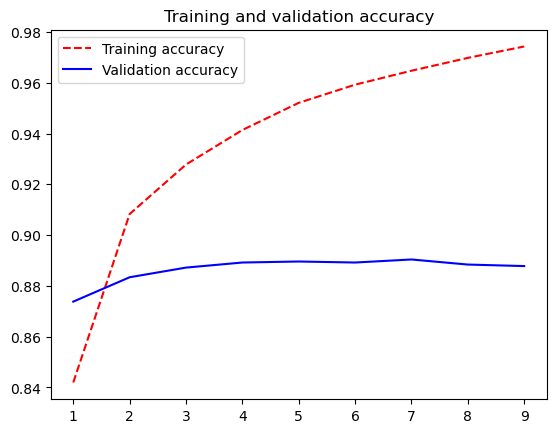

In [72]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [73]:
test_loss, test_acc = model.evaluate(bag_of_words_test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8883 - loss: 0.2822


In [74]:
test_loss

0.28268009424209595

In [75]:
test_acc

0.8870800137519836

In [76]:
max_tokens = 30_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="multi_hot",
    ngrams=2,
)

text_vectorization.adapt(train_ds_no_labels)

bigram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

bigram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

bigram_test_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

In [77]:
x, y = next(bigram_train_ds.as_numpy_iterator())

In [78]:
x.shape

(32, 30000)

In [79]:
text_vectorization.get_vocabulary()[100:108]

[np.str_('in a'),
 np.str_('most'),
 np.str_('him'),
 np.str_('dont'),
 np.str_('it was'),
 np.str_('one of'),
 np.str_('then'),
 np.str_('made')]

In [57]:
model = build_linear_classifier(max_tokens, "bigram_classifier")
model.fit(
    bigram_train_ds,
    validation_data=bigram_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8151 - loss: 0.4938 - val_accuracy: 0.8900 - val_loss: 0.3085
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9305 - loss: 0.2350 - val_accuracy: 0.8946 - val_loss: 0.2683
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9580 - loss: 0.1704 - val_accuracy: 0.8980 - val_loss: 0.2554
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9727 - loss: 0.1318 - val_accuracy: 0.8968 - val_loss: 0.2503
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9818 - loss: 0.1048 - val_accuracy: 0.8962 - val_loss: 0.2500
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9877 - loss: 0.0847 - val_accuracy: 0.8940 - val_loss: 0.2522
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9925 - loss: 0.0693 - val_accuracy: 0.8936 - val_loss: 0.2554


In [58]:
test_loss, test_acc = model.evaluate(bigram_test_ds)
test_acc

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8966 - loss: 0.2492


0.8962000012397766

In [59]:
max_length = 600
max_tokens = 30_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(train_ds_no_labels)

In [60]:
sequence_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

sequence_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

sequence_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

In [61]:
x, y = next(sequence_test_ds.as_numpy_iterator())

In [62]:
x.shape

(32, 600)

In [63]:
x

array([[   4, 1149,   50, ...,    0,    0,    0],
       [  10,  631,   10, ...,    0,    0,    0],
       [  10,  197,   11, ...,    0,    0,    0],
       ...,
       [   4,  567,    5, ...,    0,    0,    0],
       [  11,   18,    7, ...,    0,    0,    0],
       [ 922, 1300, 5221, ...,    0,    0,    0]])

In [64]:
import numpy as np
from tensorflow import keras
from keras import ops, layers

class OneHotEncoding(layers.Layer):
    def __init__(self, depth, **kwargs):
        super().__init__(**kwargs)
        self.depth = depth

    def call(self, inputs):
        flat_inputs = ops.reshape(ops.cast(inputs, "int"), [-1])
        one_hot_vectors = ops.eye(self.depth)
        outputs = ops.take(one_hot_vectors, flat_inputs, axis=0)
        return ops.reshape(outputs, ops.shape(inputs) + (self.depth,))
        

In [65]:
one_hot_encoding = OneHotEncoding(max_tokens)

In [66]:
x, y = next(sequence_train_ds.as_numpy_iterator())
one_hot_encoding(x).shape

TensorShape([32, 600, 30000])

In [80]:
hidden_dim = 64
inputs = keras.Input(shape=(max_length,), dtype="int32")
x = one_hot_encoding(inputs)
x = layers.Bidirectional(layers.LSTM(hidden_dim))(x)
x = layers.Dropout(0.5)(x)
ouputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, ouputs, name="lstm_with_one_hot")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)



In [81]:
model.summary(line_length=80)

Model: "lstm_with_one_hot"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)        │ (None, 600)              │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ one_hot_encoding (OneHotEncoding) │ (None, 600, 30000)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)     │ (None, 128)              │    15,393,280 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout (Dropout)                 │ (None, 128)              │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_3 (Dense)                   │ (None, 1)                │           129 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 15,393,409 (58.72 MB)

 Trainable params: 15,393,409 (58.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    sequence_test_ds,
    validation_data=sequence_train_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
  3/782 ━━━━━━━━━━━━━━━━━━━━ 2:02:33 9s/step - accuracy: 0.4497 - loss: 0.6942